## 🖌 프로젝트 목적 : 자사 건강보험 가입자들에 대한 차 보험에 대한 판매예측 및 요인분석을 통한 프로모션 대안 방향성 마련. 

## 1. 문제정의, 데이터 EDA, 데이터 전처리


### 1-1. 문제정의: 건강보험 가입자들 중 차 보험을 가입할 사람들이 어떤 사람들일지 예측하는 문제. 
- 평가지표: ROC-AUC score
- 선정이유: 불균형 클래스 문제를 갖고 있어 positive와 negative를 잘 분류해내는지 판단하는 ROC-AUC score를 평가지표로 사용. 
- 최적임계값 적용: 가입할 사람을 잘못 예측하여 추천하는 경우(False Positive) 마케팅 비용보다 가입할 사람인데 잘못 예측하여 놓치는 경우(False Negative)의 비용이 더 크다고 판단하여 재현율(recall)을 최대화하면서 위양성율(False Positive Rate)은 최소화하는 최적 임계값(Optimal Threshold)를 적용해 예측값을 산출할 예정. 

> #### 환경설정 (모듈 설치)

In [18]:
# 모델 파일 저장을 위한 라이브러리
!pip install joblib

In [1]:
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

     - 25.9 MB 707 kB/s
     |████████████████████████████████| 10.9 MB 4.6 MB/s 
     |████████████████████████████████| 596 kB 44.7 MB/s 
     |████████████████████████████████| 102 kB 641 kB/s 
     |████████████████████████████████| 675 kB 38.5 MB/s 
     |████████████████████████████████| 4.7 MB 32.7 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
     |████████████████████████████████| 812 kB 44.0 MB/s 
     |████████████████████████████████| 38.1 MB 291 kB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-3.1.1-py2.py3-none-any.whl size=261287 sha256=9a8310dba25b86c31f1161d5909e40330c526c2687b250596045e0423312ada1
  Stored in directory: /tmp/pip-ephem-wheel-cache-y5b9q1ej/wheels/cc/d5/09/083fb07c9363a2f45854b0e3a7de7d7c560f07da74b9e9769d
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27098 sha256=86887d5a8475c490cf808ca6c04f590c3a118af6a771fc1df62bf6bb3308e0fb
  Stored in directory: /root/.cache/pip/wheels/70/e1/52/5b14d

In [2]:
!pip install category_encoders

     |████████████████████████████████| 82 kB 432 kB/s 


In [3]:
!pip install pdpbox

     |████████████████████████████████| 34.0 MB 1.2 MB/s 
     |████████████████████████████████| 13.1 MB 29.3 MB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.1-py3-none-any.whl size=35758224 sha256=5c2667121fb89258ac79c31b806b1f9c54775302521d6f438bd76f5a5ccd320e
  Stored in directory: /root/.cache/pip/wheels/f4/d0/1a/b80035625c53131f52906a6fc4dd690d8efd2bf8af6a4015eb
Successfully built pdpbox
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.1.1 requires matplotlib>=3.2.0, but you have matplotlib 3.1.1 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [4]:
!pip install shap

     |████████████████████████████████| 564 kB 5.1 MB/s 


### 1-2. 데이터 EDA

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# 데이터 출처: https://www.kaggle.com/anmolkumar/health-insurance-cross-sell-prediction?select=train.csv
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/#프로젝트(DS)/차보험가입예측/train.csv')
df

id  Gender  Age  ...  Policy_Sales_Channel  Vintage  Response
0            1    Male   44  ...                  26.0      217         1
1            2    Male   76  ...                  26.0      183         0
2            3    Male   47  ...                  26.0       27         1
3            4    Male   21  ...                 152.0      203         0
4            5  Female   29  ...                 152.0       39         0
...        ...     ...  ...  ...                   ...      ...       ...
381104  381105    Male   74  ...                  26.0       88         0
381105  381106    Male   30  ...                 152.0      131         0
381106  381107    Male   21  ...                 160.0      161         0
381107  381108  Female   68  ...                 124.0       74         0
381108  381109    Male   46  ...                  26.0      237         0

[381109 rows x 12 columns]

In [8]:
# test데이터 
test = pd.read_csv('/content/drive/MyDrive/#프로젝트(DS)/차보험가입예측/test.csv')
test

id  Gender  Age  ...  Annual_Premium  Policy_Sales_Channel  Vintage
0       381110    Male   25  ...         35786.0                 152.0       53
1       381111    Male   40  ...         33762.0                   7.0      111
2       381112    Male   47  ...         40050.0                 124.0      199
3       381113    Male   24  ...         37356.0                 152.0      187
4       381114    Male   27  ...         59097.0                 152.0      297
...        ...     ...  ...  ...             ...                   ...      ...
127032  508142  Female   26  ...         30867.0                 152.0       56
127033  508143  Female   38  ...         28700.0                 122.0      165
127034  508144    Male   21  ...         29802.0                 152.0       74
127035  508145    Male   71  ...         62875.0                  26.0      265
127036  508146    Male   41  ...         27927.0                 124.0      231

[127037 rows x 11 columns]

In [ ]:
# 타겟 (Response)과 독립특성 상관관계
df.corrwith(df['Response']).sort_values(ascending=False)
# 타겟과 뚜렷한 음의 상관관계 특성: 'Previously_Insured(차보험 유/무)'
# 타겟과 약한 음의 상관관계 특성: 'Policy_Sales_Channel(판매채널(구체적 정보 비공개))'
# 타겟과 약한 양의 상관관계 특성: 'Age(나이)'

# 피어슨 상관계수 해석 기준 참고: 
# r이 -1.0과 -0.7 사이이면, 강한 음적 선형관계,
# r이 -0.7과 -0.3 사이이면, 뚜렷한 음적 선형관계,
# r이 -0.3과 -0.1 사이이면, 약한 음적 선형관계,
# r이 -0.1과 +0.1 사이이면, 거의 무시될 수 있는 선형관계,
# r이 +0.1과 +0.3 사이이면, 약한 양적 선형관계,
# r이 +0.3과 +0.7 사이이면, 뚜렷한 양적 선형관계,
# r이 +0.7과 +1.0 사이이면, 강한 양적 선형관계

Response                1.000000
Age                     0.111147
Annual_Premium          0.022575
Region_Code             0.010570
Driving_License         0.010155
Vintage                -0.001050
id                     -0.001368
Policy_Sales_Channel   -0.139042
Previously_Insured     -0.341170
dtype: float64

In [ ]:
# 운전면허 있는 그룹
df1 = df[(df['Driving_License'] == 1)]
df1.corrwith(df1['Response']).sort_values(ascending=False)

Response                1.000000
Age                     0.112568
Annual_Premium          0.022779
Region_Code             0.010642
Vintage                -0.000996
id                     -0.001332
Policy_Sales_Channel   -0.139882
Previously_Insured     -0.341651
Driving_License              NaN
dtype: float64

In [83]:
# 운전면허 있고, 차보험 없는 그룹 
df1 = df[(df['Driving_License'] == 1) & (df['Previously_Insured']==0)]
df1.corrwith(df1['Response']).sort_values(ascending=False)

Response                1.000000
Age                     0.038115
Annual_Premium          0.033518
Region_Code             0.003450
Vintage                -0.000239
id                     -0.000760
Policy_Sales_Channel   -0.090771
Driving_License              NaN
Previously_Insured           NaN
dtype: float64

In [ ]:
# 운전면허 없는 그룹 --> 당연하겠지만, 상관성이 약하므로 예측에서 배제할 것. 
df0 = df[(df['Driving_License'] == 0)]
df0.corrwith(df0['Response']).sort_values(ascending=False)

Response                1.000000
Policy_Sales_Channel    0.053729
id                     -0.022780
Annual_Premium         -0.027168
Vintage                -0.033484
Region_Code            -0.035678
Age                    -0.143815
Previously_Insured     -0.149815
Driving_License              NaN
dtype: float64

In [ ]:
# 불균형 클래스 문제. class-weight 조정할 것. 평가지표 캐글기준으로는 ROC스코어, F1스코어 같이 볼 것. 
df1['Response'].value_counts(normalize=True)

0    0.877283
1    0.122717
Name: Response, dtype: float64

In [ ]:
import pandas as pd 
import pandas_profiling

In [ ]:
# 판다스 프로파일링 확인 결과 특성들간 상관관계 높은 것으로 보아 다중공선성 문제 의심됨. --> 트리모델 사용하기로 결정. 
# 결측치, 중복 없음.
pr=df.profile_report()
pr.to_file('./pr_report.html')
pr

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:4812: RuntimeWarning: overflow encountered in long_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### 1-3. 데이터 전처리
- 운전면허 있고, 차보험 가입이 없는 고객으로 선별
- 범주형 인코딩(ordinal encoder 사용) -> 트리모델 적용예정. 

In [49]:
# Feature engineering, train 데이터 생성. 
def engineer(df):
  train = df[(df['Driving_License'] == 1) & (df['Previously_Insured']==0)]
  return train

train = engineer(df)
train

id  Gender  Age  ...  Policy_Sales_Channel  Vintage  Response
0            1    Male   44  ...                  26.0      217         1
1            2    Male   76  ...                  26.0      183         0
2            3    Male   47  ...                  26.0       27         1
5            6  Female   24  ...                 160.0      176         0
6            7    Male   23  ...                 152.0      249         0
...        ...     ...  ...  ...                   ...      ...       ...
381100  381101  Female   29  ...                 124.0      137         0
381101  381102  Female   70  ...                 122.0      215         0
381103  381104    Male   47  ...                  26.0      235         0
381107  381108  Female   68  ...                 124.0       74         0
381108  381109    Male   46  ...                  26.0      237         0

[205910 rows x 12 columns]

In [ ]:
train.Driving_License.value_counts()

1    380297
Name: Driving_License, dtype: int64

In [ ]:
#결측치 다시 확인 : False(결측치 없음) / True(결측치 있음)
train.isnull().values.any()

False

In [ ]:
#중복샘플 유무 확인 : False(중복값 없음) / True(중복값 없음)
train.duplicated().value_counts()

False    380297
dtype: int64


## 2. 모델링(트리 앙상블 모델, k-fold CV사용)

### 2-1. 클래스 분포, 기준모델 ROC_AUC_SCORE확인

In [50]:
# 불균형 클래스 문제. class-weight 조정할 것. 
train['Response'].value_counts(normalize=True)

0    0.77412
1    0.22588
Name: Response, dtype: float64

In [51]:
# mode(): Return the highest frequency value in a Series.
majority_class = train.Response.mode()[0]

# 타겟 샘플 수 만큼 0이 담긴 리스트. 기준모델로 예측
y_pred = [majority_class] * len(train)

In [52]:
# 기준모델 roc_auc_score: 0.5 
from sklearn.metrics import roc_auc_score
roc_auc_score(train.Response, y_pred)


0.5

### 2-2. 모델링 (파이프라인, K-fold CV)

#### 모델1 - hold-out 검증 사용, class-weight

In [53]:
# 사용 모듈 
from scipy.stats import randint, uniform
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV


In [54]:
target = 'Response'
X_train = train.drop(columns='Response')
y_train = train[target]
X_train.shape, y_train.shape

((205910, 11), (205910,))

In [55]:
# train, validation 데이터셋 분리
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.33, random_state=42) # train을 resampling할 예정이므로 stratify 설정 안 함.

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((137959, 11), (67951, 11), (137959,), (67951,))

In [56]:
# 모델1
# pipeline - ordinal encoding, randomforestclassifier
pipe = make_pipeline(
    OrdinalEncoder(), 
    RandomForestClassifier(random_state=2, class_weight='balanced')
)

pipe.fit(X_train, y_train)

pipe.score(X_val, y_val) #accuracy score


0.7661255904990361

In [57]:
# 모델1 - roc_auc_score
y_train_pred = pipe.predict(X_train)
y_val_pred = pipe.predict(X_val)
from sklearn.metrics import roc_auc_score
print('훈련 ROC-AUC score:', roc_auc_score(y_train, y_train_pred))
print('검증 ROC-AUC score:', roc_auc_score(y_val, y_val_pred))

훈련 ROC-AUC score: 0.999951810325441
검증 ROC-AUC score: 0.5176289389829631


In [58]:
# 모델 파일 저장
import pickle
saved_model = pickle.dumps(pipe)
model = pickle.loads(saved_model)

from joblib import dump, load
dump(model, 'model1.joblib') 
saved_model_file = load('model1.joblib')
saved_model_file.predict(X_train[0:1])

array([0])

#### 모델2 - undersampling 선택
- 이유: 0과 1을 균등하게 학습시키기 위해 학습데이터에 undersampling 적용. colab환경이라는 제약조건 상 시간 리소스를 고려하여 undersampling적용.

In [20]:
!pip install imbalanced-learn

In [21]:
# check version number
import imblearn
print(imblearn.__version__)

0.8.1


In [59]:
# 참고: https://www.kaggle.com/residentmario/undersampling-and-oversampling-imbalanced-data
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
rs = RandomUnderSampler(random_state=0)
rs.fit(X_train, y_train)
X_train_rs, y_train_rs = rs.fit_resample(X_train, y_train)
print('y_train_rs 클래스 비율: \n', y_train_rs.value_counts(normalize=True))
print('X_train_rs.shape:', X_train_rs.shape), 
print('y_train_rs.shape:', y_train_rs.shape)


y_train_rs 클래스 비율: 
 0    0.5
1    0.5
Name: Response, dtype: float64
X_train_rs.shape: (62254, 11)
y_train_rs.shape: (62254,)


In [60]:
# validation 은 resampling하지 않음. 
print('y_val 클래스 비율: \n', y_val.value_counts(normalize=True))
print('X_val.shape:', X_val.shape), 
print('y_val.shape:', y_val.shape)

y_val 클래스 비율: 
 0    0.773602
1    0.226398
Name: Response, dtype: float64
X_val.shape: (67951, 11)
y_val.shape: (67951,)


In [61]:
# 모델2
# pipeline - ordinal encoding, randomforestclassifier
pipe2 = make_pipeline(
    OrdinalEncoder(), 
    RandomForestClassifier(random_state=2)
)

pipe2.fit(X_train_rs, y_train_rs)


Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Gender', 'Vehicle_Age',
                                      'Vehicle_Damage'],
                                mapping=[{'col': 'Gender',
                                          'data_type': dtype('O'),
                                          'mapping': Male      1
Female    2
NaN      -2
dtype: int64},
                                         {'col': 'Vehicle_Age',
                                          'data_type': dtype('O'),
                                          'mapping': < 1 Year     1
1-2 Year     2
> 2 Years    3
NaN         -2
dtype: int64},
                                         {'col': 'Vehicle_Damage',
                                          'data_type': dtype('O'),
                                          'mapping': Yes    1
No     2
NaN   -2
dtype: int64}])),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=2))])

In [62]:
# 모델 파일 저장
import pickle
saved_model = pickle.dumps(pipe2)
model = pickle.loads(saved_model)

from joblib import dump, load
dump(model, 'model2.joblib') 
saved_model_file = load('model2.joblib')
saved_model_file.predict(X_train_rs[0:1])

array([0])

In [63]:
# train, val - accuracy score 과적합 의심.
from sklearn.metrics import accuracy_score
y_train_pred2 = pipe2.predict(X_train)
print("훈련 accuracy_score:", accuracy_score(y_train, y_train_pred2))
print("검증 accuracy_score:", pipe2.score(X_val, y_val)) # accuracy
# y_val_pred2 = pipe2.predict(X_val)
# print(accuracy_score(y_val, y_val_pred2))


훈련 accuracy_score: 0.767648359295153
검증 accuracy_score: 0.6007122779650041


In [64]:
# 모델2 train, val - roc_auc_score 
y_train_pred = pipe2
y_val_pred2 = pipe2.predict(X_val)
from sklearn.metrics import roc_auc_score
print('훈련 roc_auc:', roc_auc_score(y_train, y_train_pred2))
print('검증 roc_auc:', roc_auc_score(y_val, y_val_pred2))

훈련 roc_auc: 0.8499747266736558
검증 roc_auc: 0.6311193344113623


In [65]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_val_pred2))

              precision    recall  f1-score   support

           0       0.86      0.58      0.69     52567
           1       0.32      0.69      0.44     15384

    accuracy                           0.60     67951
   macro avg       0.59      0.63      0.56     67951
weighted avg       0.74      0.60      0.63     67951



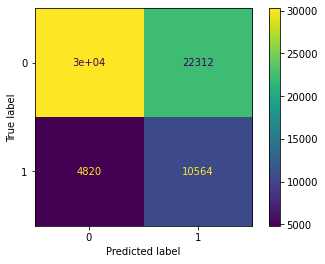

In [66]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(pipe2, X_val, y_val)  
plt.show()


#### 모델3 - 과적합 해결하기 (k-fold CV와 resampling 기법 합치기) 
- 과적합 문제 해결 위해 GridSearchCV, undersampling 기법 합쳐서 사용

In [67]:
# 모델3
# pipeline - ordinal encoding, randomforestclassifier
pipe3 = make_pipeline(
    OrdinalEncoder(), 
    RandomForestClassifier(random_state=2
                           , max_depth=2
                           , n_estimators=5
                           , min_samples_split=1000
                          
                           )
)

pipe3.fit(X_train_rs, y_train_rs)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Gender', 'Vehicle_Age',
                                      'Vehicle_Damage'],
                                mapping=[{'col': 'Gender',
                                          'data_type': dtype('O'),
                                          'mapping': Male      1
Female    2
NaN      -2
dtype: int64},
                                         {'col': 'Vehicle_Age',
                                          'data_type': dtype('O'),
                                          'mapping': < 1 Year     1
1-2 Year     2
> 2 Years    3
NaN         -2
dtype: int64},
                                         {'col': 'Vehicle_Damage',
                                          'data_type': dtype('O'),
                                          'mapping': Yes    1
No     2
NaN   -2
dtype: int64}])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=2, min_samples_split=1000,
    

In [68]:
# 모델3 
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE 
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

model = Pipeline([
        ('Ord_enc', OrdinalEncoder()),
        ('sampling', RandomUnderSampler(random_state=0)),
        # ('sampling', SMOTE(random_state=0)),
        ('rf', RandomForestClassifier(random_state=2))
    ])

param_grid = { 
    'rf__n_estimators': [10,50,100],
    'rf__max_features': ['auto', 'sqrt', 'log2'],
    'rf__max_depth' : [2,3,4,5,6],
    'rf__criterion' :['gini', 'entropy']
}

grid = GridSearchCV(model, 
                    param_grid=param_grid,
                    cv=2,
                    refit=True,
                    scoring='roc_auc')
grid.fit(X_train, y_train)

## Import up sound alert dependencies
from IPython.display import Audio, display

def allDone():
  display(Audio(url='https://freesound.org/data/previews/219/219244_4082826-lq.mp3', autoplay=True))
# https://sound.peal.io/ps/audios/000/000/537/original/woo_vu_luvub_dub_dub.wav
## Insert whatever audio file you want above
allDone()

In [69]:
# 모델 파일 저장
import pickle
saved_model = pickle.dumps(grid)
model = pickle.loads(saved_model)

from joblib import dump, load
dump(model, 'model3.joblib') 
saved_model_file = load('model3.joblib')
saved_model_file.predict(X_train_rs[0:1])

array([0])

In [70]:
#best score, best params
grid.best_score_, grid.best_params_

(0.6918580981662921,
 {'rf__criterion': 'gini',
  'rf__max_depth': 6,
  'rf__max_features': 'auto',
  'rf__n_estimators': 100})

In [71]:
pd.DataFrame(grid.cv_results_).sort_values(by='rank_test_score').T

44  ...                                                 0 
mean_fit_time                                                    2.072784  ...                                           0.206479
std_fit_time                                                     0.012508  ...                                           0.012197
mean_score_time                                                  0.589239  ...                                           0.089633
std_score_time                                                    0.00078  ...                                           0.001211
param_rf__criterion                                                  gini  ...                                               gini
param_rf__max_depth                                                     6  ...                                                  2
param_rf__max_features                                               log2  ...                                               auto
param_rf__n_estimators                                                100  ...                                                 10
params                  {'rf__criterion': 'gini', 'rf__max_depth': 6, ...  ...  {'rf__criterion': 'gini', 'rf__max_depth': 2, ...
split0_test_score                                                0.689772  ...                                             0.6338
split1_test_score                                                0.693944  ...                                           0.636024
mean_test_score                                                  0.691858  ...                                           0.634912
std_test_score                                                   0.002086  ...                                           0.001112
rank_test_score                                                         1  ...                                                 88

[14 rows x 90 columns]

In [72]:
# best model 저장
best_model = grid.best_estimator_

In [73]:
# 모델3 train, val - roc_auc_score
y_val_pred_b = best_model.predict(X_val)
from sklearn.metrics import roc_auc_score
print('grid_best_roc_auc_score:', grid.best_score_)
print('검증 roc_auc_score:', roc_auc_score(y_val, y_val_pred_b))

grid_best_roc_auc_score: 0.6918580981662921
검증 roc_auc_score: 0.6439014229677182


## 3. 모델 해석 - shap, permutation importance

### 3-1. SHAP 

In [86]:
# X_val 인코딩
enc = best_model.named_steps['Ord_enc']
X_train_enc = enc.fit_transform(X_train)
X_val_enc = enc.transform(X_val)

In [87]:
X_val_enc[:1]

id  Gender  Age  ...  Annual_Premium  Policy_Sales_Channel  Vintage
250418  250419       1   40  ...         33309.0                 124.0      155

[1 rows x 11 columns]

In [88]:
# best_model 속성 확인
best_model.named_steps

{'Ord_enc': OrdinalEncoder(cols=['Gender', 'Vehicle_Age', 'Vehicle_Damage'],
                mapping=[{'col': 'Gender', 'data_type': dtype('O'),
                          'mapping': Female    1
 Male      2
 NaN      -2
 dtype: int64},
                         {'col': 'Vehicle_Age', 'data_type': dtype('O'),
                          'mapping': 1-2 Year     1
 < 1 Year     2
 > 2 Years    3
 NaN         -2
 dtype: int64},
                         {'col': 'Vehicle_Damage', 'data_type': dtype('O'),
                          'mapping': Yes    1
 No     2
 NaN   -2
 dtype: int64}]),
 'rf': RandomForestClassifier(max_depth=6, random_state=2),
 'sampling': RandomUnderSampler(random_state=0)}

In [118]:
# False Positive 사례.(예측은 1로 했으나, 실제 0인 경우)

# pipeline with SHAP 해결 - 참고: https://stackoverflow.com/questions/55867862/how-to-use-shap-with-a-linear-svc-model-from-sklearn-using-pipeline
# SHAP Force Plot

enc = best_model.named_steps['Ord_enc']
X_train_enc = enc.fit_transform(X_train)
X_val_enc = enc.transform(X_val)
model = best_model.named_steps['rf']

y_val_pred3 = best_model.predict(X_val_enc)

print('실제값:', y_val[:1].iloc[0])
print('예측값:', y_val_pred3[:1])

import shap
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val_enc[:1])
shap.force_plot(explainer.expected_value[1], 
                shap_values=shap_values[1], 
                features=X_val_enc[:1])

실제값: 0
예측값: [1]


In [150]:
# True Positive 사례. (예측 1, 실제 1인 경우)
print('실제값: ', y_val[2:3].iloc[0])
print('예측값: ', y_val_pred3[2:3])

import shap
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val_enc[2:3])
shap.force_plot(explainer.expected_value[1], 
                shap_values=shap_values[1], 
                features=X_val_enc[2:3])

실제값:  1
예측값:  [1]


In [142]:
print(y_val[200:210])
print(y_val_pred3[200:210])

281408    1
360246    0
234630    1
361973    1
374294    0
239136    0
249766    1
354056    0
237082    0
282482    1
Name: Response, dtype: int64
[0 1 0 0 1 1 1 1 0 1]


In [149]:
# True Negative 사례. (예측 0, 실제 0인 경우)
print('실제값: ', y_val[208:209].iloc[0])
print('예측값: ', y_val_pred3[208:209])

import shap
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val_enc[208:209])
shap.force_plot(explainer.expected_value[1], 
                shap_values=shap_values[1], 
                features=X_val_enc[208:209])

실제값:  0
예측값:  [0]


In [147]:
# False Negative 사례. (예측 0, 실제 1인 경우)
print('실제값: ', y_val[200:201].iloc[0])
print('예측값: ', y_val_pred3[200:201])

import shap
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val_enc[200:201])
shap.force_plot(explainer.expected_value[1], 
                shap_values=shap_values[1], 
                features=X_val_enc[200:201])

실제값:  1
예측값:  [0]


In [148]:
# False Negative 사례. (예측 0, 실제 1인 경우)
print('실제값: ', y_val[202:203].iloc[0])
print('예측값: ', y_val_pred3[202:203])

import shap
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val_enc[202:203])
shap.force_plot(explainer.expected_value[1], 
                shap_values=shap_values[1], 
                features=X_val_enc[202:203])

실제값:  1
예측값:  [0]


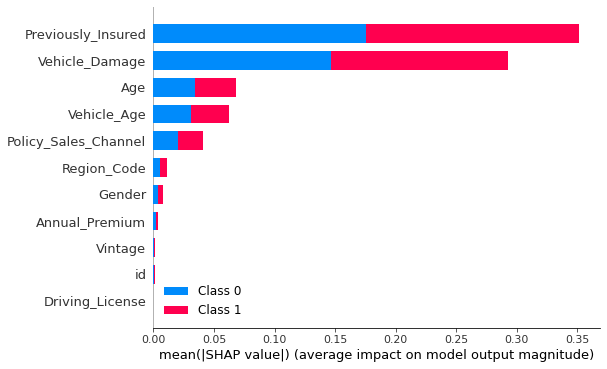

In [ ]:
# summary plot, 0과 1 모두에게 가장 크게 기여하는 특성들 확인할 수 있음. 
shap_values = explainer.shap_values(X_val_enc.iloc[:300])
shap.summary_plot(shap_values, X_val_enc.iloc[:300])

### 3-2. Permuation importance(특성중요도)
 - 해당 특성의 효과를 무력화시킨 후(노이즈 줌) 성능을 여러번 측정하여 평균값으로 낸 것. 
 - [공식 문서 참고](https://scikit-learn.org/stable/modules/permutation_importance.html#:~:text=Permutation%20feature%20importance%20is%20a,when%20the%20data%20is%20tabular.&text=The%20permutation%20feature%20importance%20is,value%20is%20randomly%20shuffled%201.)

In [ ]:
!pip install eli5

In [76]:
# X_val 인코딩
enc = best_model.named_steps['Ord_enc']
X_train_enc = enc.fit_transform(X_train)
X_val_enc = enc.transform(X_val)


In [77]:
import eli5
from eli5.sklearn import PermutationImportance

# permuter 정의
model = best_model
permuter = PermutationImportance(
    model,
    scoring='roc_auc', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업입니다
permuter.fit(X_val_enc, y_val);

In [78]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

# 특성별 score 확인
eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names # list 형식으로 넣어야 합니다
)

# 성능에 영향미치는 중요한 특성들 순위: Previously_Insured, Vehicle_Damage, Age, ... 
# 해석방법: 상위에 있을수록 해당 특성이 없을 때 성능감소가 많다는 것! 

### 3-3. PDP

In [79]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

In [80]:
X_train_rs.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage'],
      dtype='object')

In [36]:
# X_val 인코딩
enc = best_model.named_steps['Ord_enc']
X_train_enc = enc.fit_transform(X_train)
X_val_enc = enc.transform(X_val)


<Figure size 1200x1200 with 0 Axes>

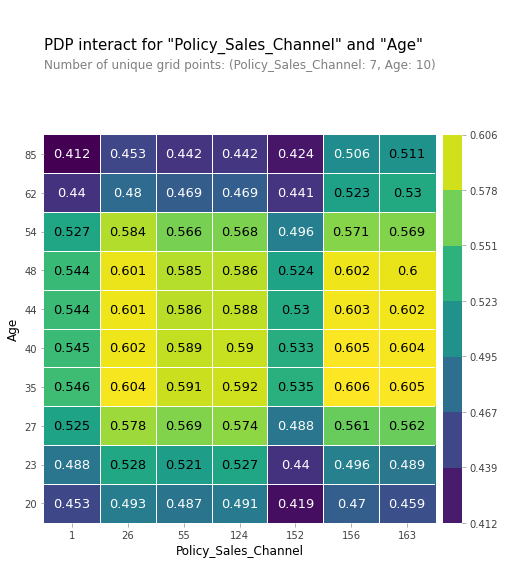

In [82]:
features = ['Policy_Sales_Channel', 'Age']

interaction = pdp_interact(
    model=best_model, 
    dataset=X_val_enc,
    model_features=X_val_enc.columns, 
    features=features
)

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8, 8), dpi=150) 

pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features, plot_params={
    # plot title and subtitle
    # 'title': 'PDP interact for "%s" and "%s"',
    # 'subtitle': 'Number of unique grid points: (%s: %d, %s: %d)',
    'title_fontsize': 15,
    'subtitle_fontsize': 12,
    # color for contour line
    'contour_color':  'white',
    'font_family': 'Arial',
    # matplotlib color map for interact plot
    'cmap': 'viridis',
    # fill alpha for interact plot
    'inter_fill_alpha': 1,
    # fontsize for interact plot text
    'inter_fontsize': 13,
});

<Figure size 1200x1200 with 0 Axes>

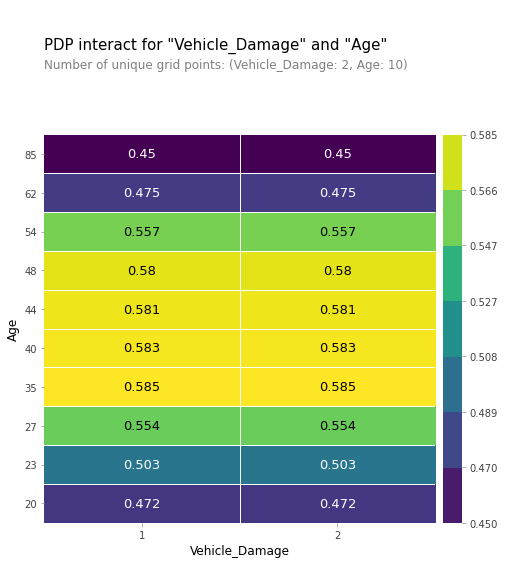

In [81]:
features = ['Vehicle_Damage', 'Age']

interaction = pdp_interact(
    model=best_model, 
    dataset=X_val_enc,
    model_features=X_val_enc.columns, 
    features=features
)

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8, 8), dpi=150) 

pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features, plot_params={
    # plot title and subtitle
    # 'title': 'PDP interact for "%s" and "%s"',
    # 'subtitle': 'Number of unique grid points: (%s: %d, %s: %d)',
    'title_fontsize': 15,
    'subtitle_fontsize': 12,
    # color for contour line
    'contour_color':  'white',
    'font_family': 'Arial',
    # matplotlib color map for interact plot
    'cmap': 'viridis',
    # fill alpha for interact plot
    'inter_fill_alpha': 1,
    # fontsize for interact plot text
    'inter_fontsize': 13,
});

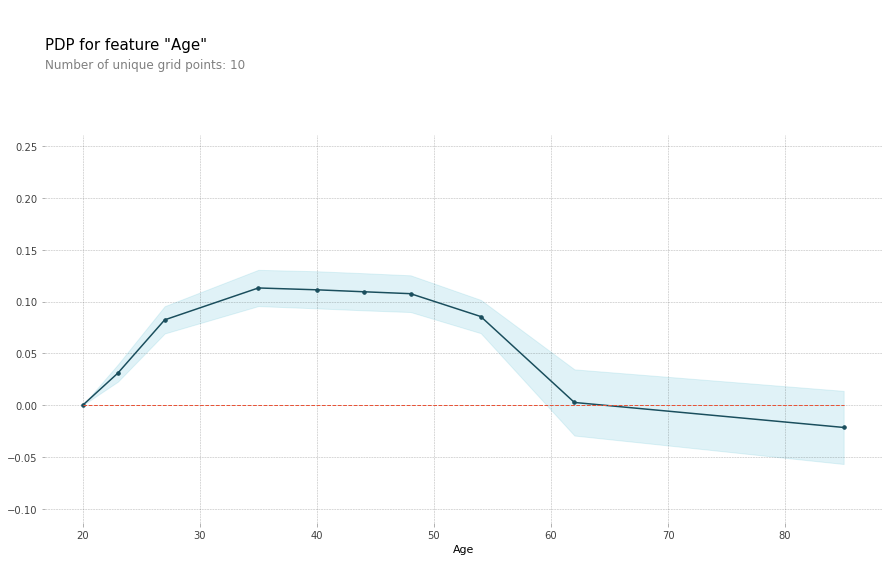

In [145]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'Age'

isolated = pdp_isolate(
    model=best_model, 
    dataset=X_val_enc, 
    model_features=X_val.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated, feature_name=feature);

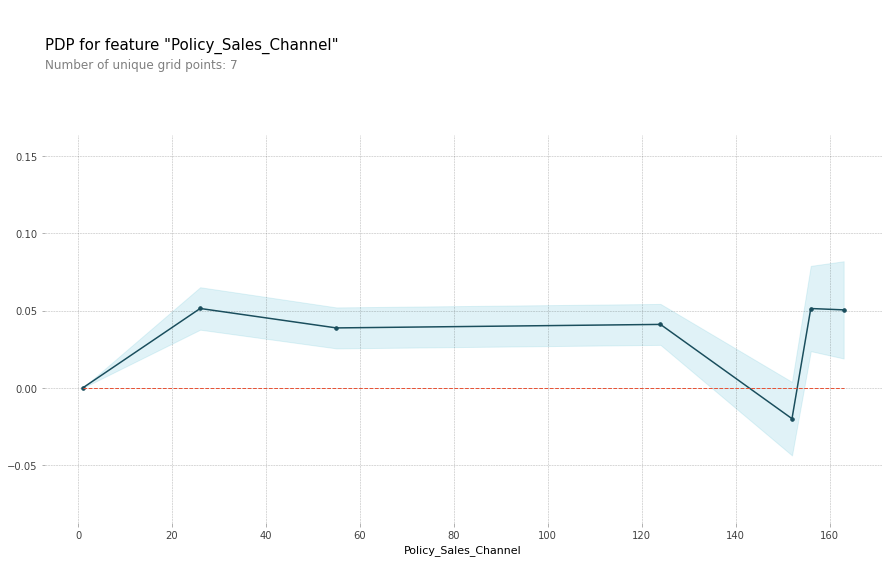

In [151]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'Policy_Sales_Channel'

isolated = pdp_isolate(
    model=best_model, 
    dataset=X_val_enc, 
    model_features=X_val.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated, feature_name=feature);

In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'Policy_Sales_Channel'

isolated = pdp_isolate(
    model=best_model, 
    dataset=X_val_enc, 
    model_features=X_val.columns, 
    feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
pdp_plot(isolated, feature_name=feature);